## <p style="background-color: #f5df18; padding: 10px;"> Foundations of Astronomical Data Science | **Plotting and Pandas** </p>


<div style="display: flex;">
    <div style="flex: 1; margin-right: 10px;">
        <h2>Questions</h2>
        <ul>
            <li>How do efficiently explore our data and identify appropriate filters to produce a clean sample (in this case of GD-1 stars)?</li>
        </ul>
    </div>
    <div style="flex: 1;">
        <h2>Learning Objectives</h2>
        <ul>
            <li>Use a Boolean Pandas <code>Series</code> to select rows in a <code>DataFrame</code>.</li>
    <li>Save multiple <code>DataFrame</code>s in an HDF5 file.</li>
        </ul>
    </div>
</div>

In the previous episode, we wrote a query to select stars from the region of the sky where we expect GD-1 to be, and saved the results in a FITS and HDF5 file.

Now we will read that data back in and implement the next step in the analysis, identifying stars with the proper motion we expect for GD-1.

# Outline
---

1. We will put those results into a Pandas `DataFrame`, which we will use
  to select stars near the centerline of GD-1.

2. Plotting the proper motion of those stars, we will identify a region
  of proper motion for stars that are likely to be in GD-1.

3. Finally, we will select and plot the stars whose proper motion is in
  that region.
  

# Exploring data

---

One benefit of using Pandas is that it provides functions for
exploring the data and checking for problems.
One of the most useful of these functions is `describe`, which
computes summary statistics for each column.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

filename = 'gd1_data.hdf'
results_df = pd.read_hdf(filename, 'results_df')

results_df.describe()

,SOURCE_ID,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
count,1.403390e+05,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000
mean,6.792399e+17,143.823122,26.780285,-2.484404,-6.100777,0.179492,-50.091158,-1.803301,-0.868963,1.409208
std,3.792177e+16,3.697850,3.052592,5.913939,7.202047,0.759590,2.892344,3.444398,6.657714,6.518615
min,6.214900e+17,135.425699,19.286617,-106.755260,-138.065163,-15.287602,-54.999989,-8.029159,-115.275637,-161.150142
25%,6.443517e+17,140.967966,24.592490,-5.038789,-8.341561,-0.035981,-52.602952,-4.750426,-2.948723,-1.107128
50%,6.888060e+17,143.734409,26.746261,-1.834943,-4.689596,0.362708,-50.147362,-1.671502,0.585037,1.987149
75%,6.976579e+17,146.607350,28.990500,0.452893,-1.937809,0.657637,-47.593279,1.160514,3.001768,4.628965
max,7.974418e+17,152.777393,34.285481,104.319923,20.981070,0.999957,-44.999985,4.014609,39.802471,79.275199


## <p style="background-color: #f5df18; padding: 10px;"> 🛑 Exercise (10 Minutes) </p>

---
Review the summary statistics in this table.

- Do the values make sense based on what you know about the context?

- Do you see any values that seem problematic, or evidence of other data issues?


## Solution

The most noticeable issue is that some of the
parallax values are negative, which seems non-physical.

Negative parallaxes in the Gaia database can arise from a number of
causes like source confusion (high negative values) and the parallax
zero point with systematic errors (low negative values).

Fortunately, we do not use the parallax measurements in
the analysis (one of the reasons we used constant distance
for reflex correction).


# Plot proper motion

---

Now we are ready to replicate one of the panels in Figure 1 of the Price-Whelan and Bonaca paper, the one that shows components of proper motion as a scatter plot:
<div>
<img src="https://datacarpentry.org/astronomy-python/fig/gd1-1.png" />
</div>


In this figure, the shaded area identifies stars that are likely to be
in GD-1 because:

- Due to the nature of tidal streams, we expect the proper motion for
  stars in GD-1 to be along the axis of the stream; that is, we expect
  motion in the direction of `phi2` to be near 0.

- In the direction of `phi1`, we do not have a prior expectation for
  proper motion, except that it should form a cluster at a non-zero
  value.

By plotting proper motion in the GD-1 frame, we hope to find this cluster.
Then we will use the bounds of the cluster to select stars that are
more likely to be in GD-1.

The following figure is a scatter plot of proper motion, in the GD-1
frame, for the stars in `results_df`.

Text(0, 0.5, 'Proper motion phi2 (mas/yr GD1 frame)')

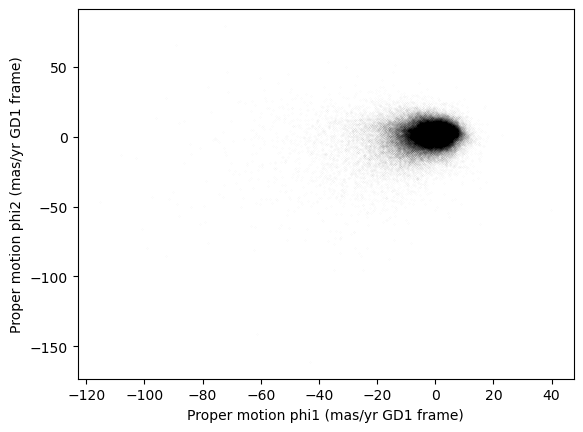

In [2]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)

plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

Most of the proper motions are near the origin, but there are a few
extreme values.
Following the example in the paper, we will use `xlim` and `ylim` to
zoom in on the region near the origin.

(-10.0, 10.0)

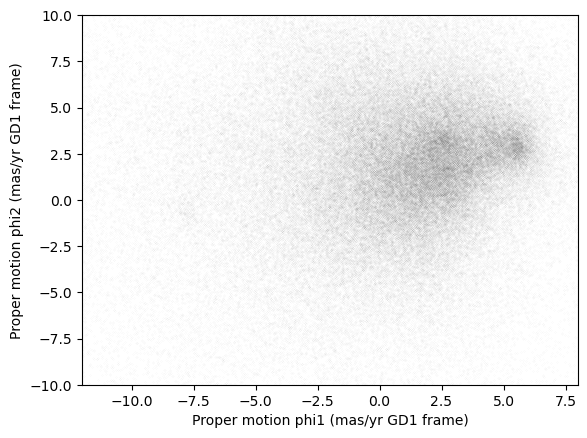

In [3]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)

plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10)

There is a hint of an overdense region near (-7.5, 0), but if you did not know where to look, you would miss it.

To see the cluster more clearly, we need a sample that contains a higher proportion of stars in GD-1. We will do that by selecting stars close to the centerline.



# Selecting the centerline

---

As we can see in the following figure, many stars in GD-1 are less
than 1 degree from the line `phi2=0`.

<div>
<img src="https://datacarpentry.org/astronomy-python/fig/gd1-4.png"/>
</div>


Stars near this line have the highest probability of being in GD-1.

To select them, we will use a "Boolean mask".  We will start by
selecting the `phi2` column from the `DataFrame`:

In [4]:
phi2 = results_df['phi2']
type(phi2)

pandas.core.series.Series

The result is a `Series`, which is the structure Pandas uses to
represent columns.

We can use a comparison operator, `>`, to compare the values in a
`Series` to a constant.

In [6]:
phi2_min = -1.0 * u.degree
phi2_max = 1.0 * u.degree

mask = (phi2 > phi2_min)
type(mask)

pandas.core.series.Series

The result is a `Series` of Boolean values, that is, `True` and `False`.

In [7]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: phi2, dtype: bool

To select values that fall between `phi2_min` and `phi2_max`, we will
use the `&` operator, which computes "logical AND".
The result is true where elements from both Boolean `Series` are true.

In [8]:
mask = (phi2 > phi2_min) & (phi2 < phi2_max)

## 🔔 **LOGICAL OPERATORS**
---

Python's logical operators (`and`, `or`, and `not`)
do not work with NumPy or Pandas.  Both libraries use the bitwise
operators (`&`, `|`, and `~`) to do elementwise logical operations
([explanation here](https://stackoverflow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas)).

Also, we need the parentheses around the conditions; otherwise the
order of operations is incorrect.

The sum of a Boolean `Series` is the number of `True` values, so we
can use `sum` to see how many stars are in the selected region.

In [9]:
mask.sum()

25084

A Boolean `Series` is sometimes called a "mask" because we can use it
to mask out some of the rows in a `DataFrame` and select the rest,
like this:


In [10]:
centerline_df = results_df[mask]
type(centerline_df)

pandas.core.frame.DataFrame

`centerline_df` is a `DataFrame` that contains only the rows from
`results_df` that correspond to `True` values in `mask`.
So it contains the stars near the centerline of GD-1.

We can use `len` to see how many rows are in `centerline_df`:


In [11]:
len(centerline_df)

25084

And what fraction of the rows we have selected.

In [12]:
len(centerline_df) / len(results_df)

0.1787386257562046

There are about 25,000 stars in this region, about 18% of the total.



# Plotting proper motion

---

This is the second time we are plotting proper motion, and we can imagine we might do it a few more times. Instead of copying and pasting the previous code, we will write a function that we can reuse on any dataframe.

In [13]:
def plot_proper_motion(df):
    """Plot proper motion.

    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (mas/yr)')
    plt.ylabel('Proper motion phi2 (mas/yr)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

And we can call it like this:

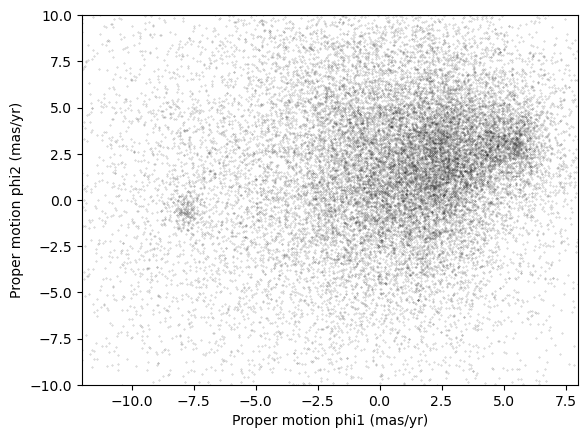

In [14]:
plot_proper_motion(centerline_df)

Now we can see more clearly that there is a cluster near (-7.5, 0).

You might notice that our figure is less dense than the one in the
paper.  That is because we started with a set of stars from a
relatively small region.  The figure in the paper is based on a region
about 10 times bigger.

In the next episode we will go back and select stars from a larger
region.  But first we will use the proper motion data to identify stars
likely to be in GD-1.

## Filtering based on proper motion
---

The next step is to select stars in the "overdense" region of proper
motion, which are candidates to be in GD-1.

In the original paper, Price-Whelan and Bonaca used a polygon to cover
this region, as shown in this figure.

<div>
<img src="https://datacarpentry.org/astronomy-python/fig/gd1-1.png" alt="Scatter plot of proper motion with overlaid polygon showing overdense region selected for analysis in Price-Whelan and Bonaca paper." />
</div>



We will use a simple rectangle for now, but in a later lesson we will see
how to select a polygonal region as well.

Here are bounds on proper motion we chose by eye:

In [15]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

To draw these bounds, we will use the `make_rectangle` function we wrote in episode 2 to make two lists containing the coordinates of the corners of the rectangle.

In [16]:
pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)

Here is what the plot looks like with the bounds we chose.

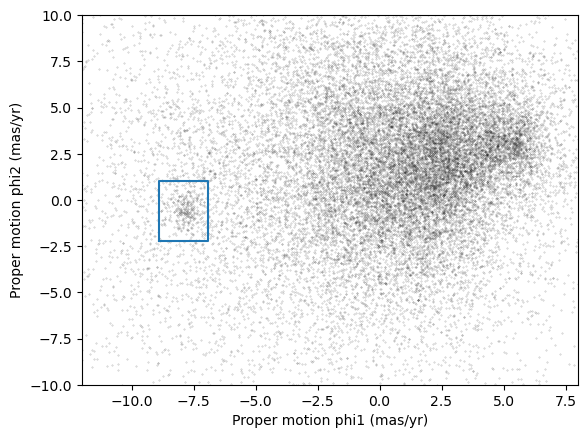

In [17]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect, '-')

Now that we have identified the bounds of the cluster in proper motion,
we will use it to select rows from `results_df`.

We will use the following function, which uses Pandas operators to make
a mask that selects rows where `series` falls between `low` and
`high`.

In [18]:
def between(series, low, high):
    """Check whether values are between `low` and `high`."""
    return (series > low) & (series < high)

The following mask selects stars with proper motion in the region we chose.

In [19]:
pm1 = results_df['pm_phi1']
pm2 = results_df['pm_phi2']

pm_mask = (between(pm1, pm1_min, pm1_max) &
           between(pm2, pm2_min, pm2_max))

Again, the sum of a Boolean series is the number of `TRUE` values.

In [20]:
pm_mask.sum()

1049

Now we can use this mask to select rows from `results_df`.

In [21]:
selected_df = results_df[pm_mask]
len(selected_df)

1049

These are the stars we think are likely to be in GD-1. We can inspect these stars, plotting their coordinates (not their proper motion).

Text(0, 0.5, 'phi2 (degree GD1)')

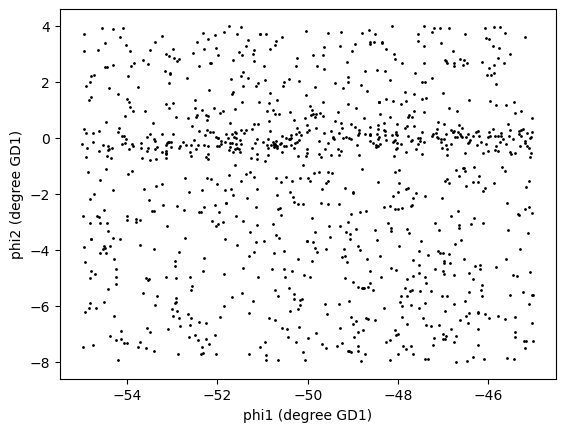

In [22]:
x = selected_df['phi1']
y = selected_df['phi2']
plt.plot(x, y, 'ko', markersize=1, alpha=1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)')

Now that is starting to look like a tidal stream!

To clean up the plot a little bit we can add two new Matplotlib commands:

- `axis` with the parameter `equal` sets up the axes so a unit is the
  same size along the `x` and `y` axes.

- `title` puts the input string as a title at the top of the plot. The `fontsize` keyword
  sets the `fontsize` to be `medium`, a little smaller than the default `large`.

In an example like this, where `x` and `y` represent coordinates in
space, equal axes ensures that the distance between points is
represented accurately. Since we are now constraining the relative proportions
of our axes, the data may not fill the entire figure.

(-55.4928032130903, -44.503699550734694, -8.606246809552195, 4.601299340488263)

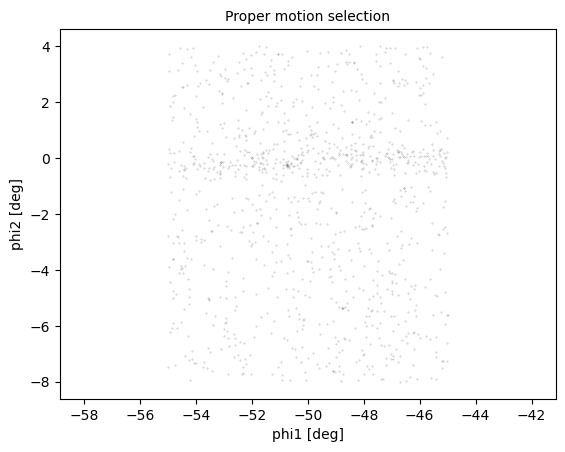

In [23]:
x = selected_df['phi1']
y = selected_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('phi1 [deg]')
plt.ylabel('phi2 [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.axis('equal')

Before we go any further, we will put the code we wrote to make one of the panel figures into a function that we will use in future episodes to recreate this entire plot with a single line of code.

In [28]:
def plot_pm_selection(df):
    """Plot in GD-1 spatial coordinates the location of the stars
    selected by proper motion
    """
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title('Proper motion selection', fontsize='medium')

    plt.axis('equal')

Now our one line plot command is:



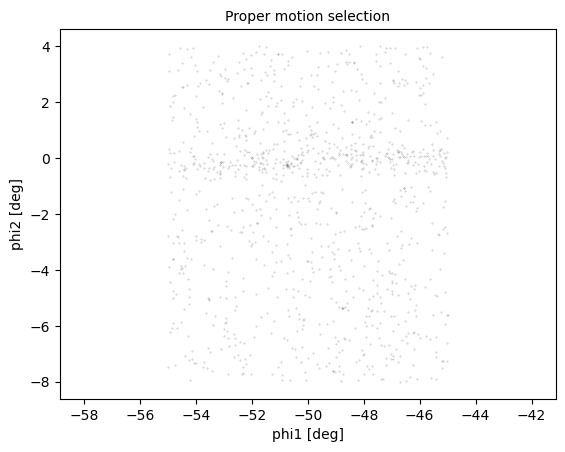

In [29]:
plot_pm_selection(selected_df)

## Saving the DataFrame
---

At this point we have run a successful query and cleaned up the
results. This is a good time to save the data.
We have already started a results file called gd1\_data.hdf which we wrote `results_df` to.

Recall that we chose HDF5 because it is a binary format producing small files that are fast to read and write and are a cross-language standard.

Additionally, HDF5 files can contain more than one dataset and can store metadata associated with each dataset (such as column names or observatory information, like a FITS header).

We can add to our existing Pandas `DataFrame` to an HDF5 file by omitting the `mode='w'` keyword like this:


In [30]:
filename = 'gd1_data.hdf'

selected_df.to_hdf(filename, 'selected_df')

/var/folders/b3/gxd2jb0s4bq1wknd7l1bnpg80000gn/T/ipykernel_15272/3890437484.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  selected_df.to_hdf(filename, 'selected_df')


Because an HDF5 file can contain more than one Dataset, we have to
provide a name, or "key", that identifies the Dataset in the file.

We could use any string as the key, but it is generally a good practice
to use a descriptive name (just like your `DataFrame` variable name) so
we will give the Dataset in the file the same name (key) as the `DataFrame`.


## <p style="background-color: #f5df18; padding: 10px;"> 🛑 Exercise (5 Minutes) </p>

---
We are going to need `centerline_df` later as well.  Write a line of
code to add it as a second Dataset in the HDF5 file.

Hint: Since the file already exists, you should *not* use `mode='w'`.


In [31]:
centerline_df.to_hdf(filename, 'centerline_df')

/var/folders/b3/gxd2jb0s4bq1wknd7l1bnpg80000gn/T/ipykernel_15272/448509805.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  centerline_df.to_hdf(filename, 'centerline_df')


We can use `getsize` to confirm that the file exists and check the size.
`getsize` returns a value in bytes. For the size files we're looking at, it will
be useful to view their size in MegaBytes (MB), so we will divide by 1024\*1024.


In [32]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

13.992622375488281

If you forget what the names of the Datasets in the file are, you can read them back like this:

In [33]:
with pd.HDFStore(filename) as hdf:
    print(hdf.keys())

['/centerline_df', '/results_df', '/selected_df']


## 🔔 Context Managers
---

We use a `with` statement here to open the file
before the print statement and (automatically) close it after.  Read
more about [context managers](https://book.pythontips.com/en/latest/context_managers.html).



The keys are the names of the Datasets which makes it easy for us to remember which DataFrame is in which Dataset.

# Summary

---
In this episode, we re-loaded the transformed Gaia data we saved from a previous query.

Then we prototyped the selection process from the Price-Whelan and Bonaca paper locally using data that we had already downloaded.:

- We selected stars near the centerline of GD-1 and made a scatter
  plot of their proper motion.

- We identified a region of proper motion that contains stars likely
  to be in GD-1.

- We used a Boolean `Series` as a mask to select stars whose proper
  motion is in that region.

So far, we have used data from a relatively small region of the sky so that our local dataset was not too big.
In the next lesson, we will write a query that selects stars based on
the proper motion limits we identified in this lesson, which will allow us to explore a larger region.

# <p style="background-color: #f5df18; padding: 10px;"> 🗝️ Key points</p>
---

- A workflow is often prototyped on a small set of data which can be explored more easily and used to identify ways to limit a dataset to exactly the data you want.
- To store data from a Pandas `DataFrame`, a good option is an HDF5 file, which can contain multiple Datasets.
